In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Copy the Data/data.zip to local
!cp /content/drive/MyDrive/Data/data.zip /content

# Unzip the data.zip file
!unzip -q data.zip

Mounted at /content/drive


# Face Emotion Recognition - Model Training

This notebook trains a **MobileNetV2-based CNN** to classify facial expressions into one of **7 emotion categories**:

| Index | Emotion   |
|-------|-----------|
| 0     | Angry     |
| 1     | Disgust   |
| 2     | Fear      |
| 3     | Happy     |
| 4     | Sad       |
| 5     | Surprise  |
| 6     | Neutral   |

## Approach

We use **transfer learning** with a pre-trained MobileNetV2 backbone from ImageNet. The final classifier layer is replaced with a custom head that outputs 7 classes. This allows the model to leverage powerful learned features while adapting to our specific emotion recognition task.

## Dataset Structure

The training images should be organized in the following folder structure:

```
data/images/
    angry/
        img001.jpg
        img002.jpg
        ...
    disgust/
        ...
    fear/
        ...
    happy/
        ...
    sad/
        ...
    surprise/
        ...
    neutral/
        ...
```

Each subfolder name must match one of the 7 emotion labels. Images can be `.jpg`, `.jpeg`, or `.png`.

---
## 1. Setup & Imports

Import all required libraries. The key dependencies are:
- **PyTorch** for model definition, training, and inference
- **torchvision** for pre-trained models and image transforms
- **PIL / Pillow** for image loading
- **matplotlib / seaborn** for visualization

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision.models as models
from PIL import Image

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available:  {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU:             {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu128
CUDA available:  True
GPU:             Tesla T4


---
## 2. Configuration

All training hyper-parameters and paths are defined here for easy modification.

In [ ]:
# ============================================================
# Configuration
# ============================================================

# Paths
DATA_DIR = "data/images"           # Root folder containing emotion sub-folders
CHECKPOINT_DIR = "checkpoints"      # Where to save trained model weights
MODEL_SAVE_PATH = os.path.join(CHECKPOINT_DIR, "face_model.pth")

# Emotion labels (must match sub-folder names in DATA_DIR)
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
NUM_CLASSES = len(EMOTIONS)

# Training hyper-parameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
VAL_SPLIT = 0.2                     # 20% of data used for validation

# Image pre-processing
IMAGE_SIZE = 224                     # MobileNetV2 expects 224x224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cuda


---
## 3. Dataset Class

A custom PyTorch `Dataset` that:
1. Scans each emotion sub-folder for images
2. Assigns integer labels (0-6) based on the `EMOTIONS` list
3. Applies image transforms on-the-fly
4. Handles corrupt images gracefully by skipping to the next sample

In [ ]:
class FaceDataset(Dataset):
    """
    Custom dataset for loading face emotion images.

    Expects folder structure:
        root_dir/
            angry/   -> images
            disgust/ -> images
            ...      -> images
    """

    SUPPORTED_EXTENSIONS = ('.jpg', '.jpeg', '.png')

    def __init__(self, root_dir: str, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []   # list of file paths
        self.labels = []   # list of integer labels

        for idx, emotion in enumerate(EMOTIONS):
            emotion_path = os.path.join(root_dir, emotion)
            if not os.path.exists(emotion_path):
                print(f"  [WARNING] Folder not found: {emotion_path}")
                continue

            count = 0
            for img_name in os.listdir(emotion_path):
                if img_name.lower().endswith(self.SUPPORTED_EXTENSIONS):
                    self.images.append(os.path.join(emotion_path, img_name))
                    self.labels.append(idx)
                    count += 1
            print(f"  {emotion:>10s}: {count:,} images")

        print(f"\n  Total: {len(self.images):,} images across {NUM_CLASSES} classes")

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int):
        try:
            image = Image.open(self.images[idx]).convert('RGB')
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            # If an image is corrupt, skip to the next one
            print(f"  [WARNING] Could not load {self.images[idx]}: {e}")
            return self.__getitem__((idx + 1) % len(self))

---
## 4. Data Transforms & Loading

We define separate transforms for training and validation:

- **Training**: Random horizontal flip + random rotation + color jitter for data augmentation
- **Validation**: Only resize and normalize (no augmentation)

Both normalize using ImageNet statistics since MobileNetV2 was pre-trained on ImageNet.

In [ ]:
# Training transforms (with data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Load full dataset (using train transforms initially for scanning)
print("Loading dataset...\n")
full_dataset = FaceDataset(DATA_DIR, transform=train_transform)

assert len(full_dataset) > 0, "ERROR: No images found! Check your data/images/ folder structure."

Loading dataset...

       angry: 3,995 images
     disgust: 436 images
        fear: 4,097 images
       happy: 7,215 images
         sad: 4,830 images
    surprise: 3,171 images
     neutral: 4,965 images

  Total: 28,709 images across 7 classes


### 4.1 Train / Validation Split

We split the dataset into training and validation sets. The validation set is used to monitor overfitting and select the best model checkpoint.

In [ ]:
# Split into train and validation sets
val_size = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

# Override the validation subset's transform to remove augmentation
# (random_split shares the underlying dataset, so we apply val_transform at inference)
# We'll handle this by creating separate datasets if needed, or applying transforms inline.

print(f"Training samples:   {train_size:,}")
print(f"Validation samples: {val_size:,}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"Training batches:   {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training samples:   22,968
Validation samples: 5,741
Training batches:   718
Validation batches: 180


### 4.2 Dataset Distribution

Visualize the class distribution to check for class imbalance.

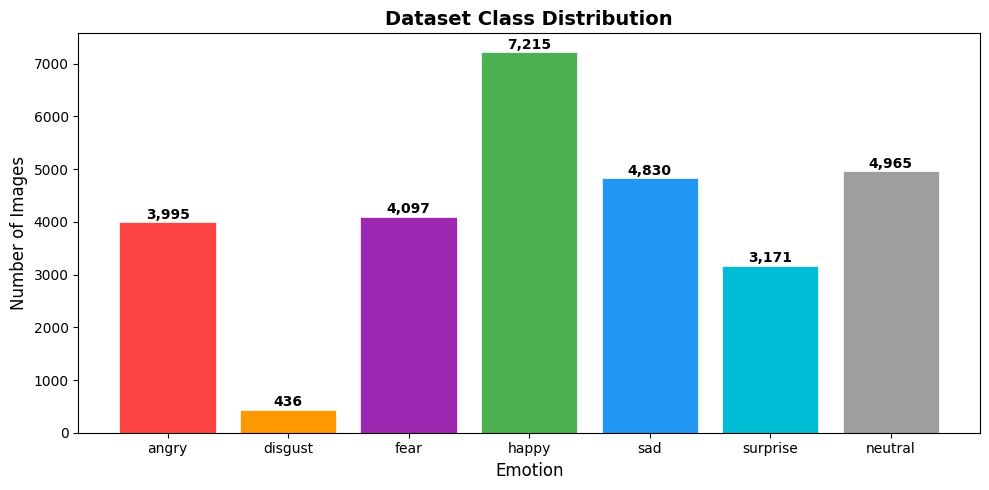

In [ ]:
# Count samples per class
label_counts = Counter(full_dataset.labels)
labels_sorted = [EMOTIONS[i] for i in range(NUM_CLASSES)]
counts_sorted = [label_counts.get(i, 0) for i in range(NUM_CLASSES)]

# Plot distribution
fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#FF4444', '#FF9800', '#9C27B0', '#4CAF50', '#2196F3', '#00BCD4', '#9E9E9E']
bars = ax.bar(labels_sorted, counts_sorted, color=colors, edgecolor='white', linewidth=0.5)
ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Dataset Class Distribution', fontsize=14, fontweight='bold')

# Add count labels on bars
for bar, count in zip(bars, counts_sorted):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
            f'{count:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 4.3 Sample Images Preview

Display a few sample images from the dataset to verify loading is correct.

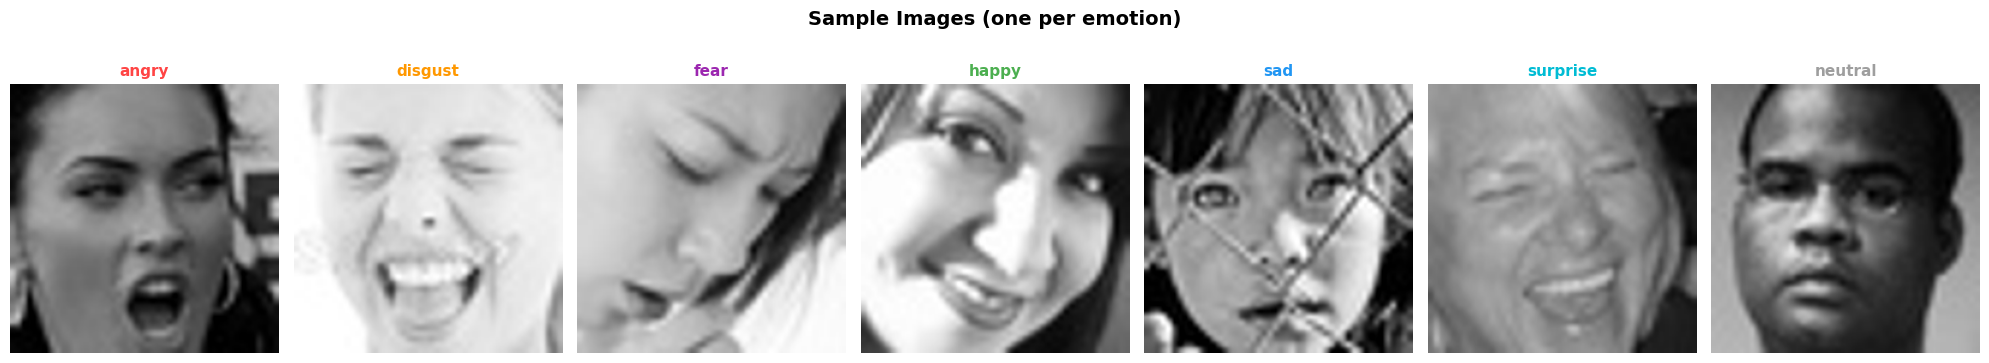

In [ ]:
# Show sample images (one per class)
fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(20, 4))
fig.suptitle('Sample Images (one per emotion)', fontsize=14, fontweight='bold')

shown = set()
for img_path, label in zip(full_dataset.images, full_dataset.labels):
    if label not in shown:
        try:
            img = Image.open(img_path).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
            axes[label].imshow(img)
            axes[label].set_title(EMOTIONS[label], fontsize=11, fontweight='bold',
                                  color=colors[label])
            axes[label].axis('off')
            shown.add(label)
        except Exception:
            pass
    if len(shown) == NUM_CLASSES:
        break

plt.tight_layout()
plt.show()

---
## 5. Model Architecture

We use **MobileNetV2** pre-trained on ImageNet as the backbone. The architecture:

1. **Feature Extractor**: MobileNetV2 convolutional layers (frozen initially, or fine-tuned)
2. **Classifier Head**: Dropout (0.2) + Linear layer mapping to 7 emotion classes

MobileNetV2 is lightweight and efficient, making it ideal for real-time emotion detection.

In [ ]:
class FaceEmotionCNN(nn.Module):
    """
    Face Emotion Classification model based on MobileNetV2.

    Uses transfer learning from ImageNet pre-trained weights.
    The final classifier is replaced with a custom head for
    7-class emotion classification.
    """

    def __init__(self, num_classes: int = 7):
        super(FaceEmotionCNN, self).__init__()
        # Load pre-trained MobileNetV2
        self.mobilenet = models.mobilenet_v2(
            weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
        )
        # Replace the classifier head
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.mobilenet.last_channel, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.mobilenet(x)


# Instantiate and move to device
model = FaceEmotionCNN(num_classes=NUM_CLASSES).to(DEVICE)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters:     {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model on device:      {DEVICE}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 140MB/s]


Total parameters:     2,232,839
Trainable parameters: 2,232,839
Model on device:      cuda


---
## 6. Loss Function & Optimizer

- **Loss**: CrossEntropyLoss (standard for multi-class classification)
- **Optimizer**: Adam with learning rate scheduling
- **Scheduler**: ReduceLROnPlateau reduces the learning rate when validation loss plateaus

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

print(f"Loss function: {criterion}")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print("Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")


Loss function: CrossEntropyLoss()
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)


---
## 7. Training Loop

The training loop:
1. Iterates over epochs
2. For each epoch, trains on all batches and computes training loss/accuracy
3. Evaluates on the validation set
4. Saves the best model (lowest validation loss)
5. Applies learning rate scheduling based on validation loss

Training history is stored for later visualization.

In [ ]:
# ============================================================
# Training
# ============================================================

# History for plotting
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [],   'val_acc': [],
}

best_val_loss = float('inf')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"Starting training for {NUM_EPOCHS} epochs...")
print("=" * 70)

for epoch in range(NUM_EPOCHS):
    # ----- Training phase -----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{NUM_EPOCHS} | "
                  f"Batch {batch_idx+1}/{len(train_loader)} | "
                  f"Loss: {loss.item():.4f}")

    train_loss = running_loss / total
    train_acc = 100.0 * correct / total

    # ----- Validation phase -----
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / val_total
    val_acc = 100.0 * val_correct / val_total

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        save_marker = " ** SAVED **"
    else:
        save_marker = ""

    print(f"\n  Epoch {epoch+1}/{NUM_EPOCHS} Complete"
          f"  |  Train Loss: {train_loss:.4f}  Acc: {train_acc:.2f}%"
          f"  |  Val Loss: {val_loss:.4f}  Acc: {val_acc:.2f}%"
          f"  |  LR: {current_lr:.6f}{save_marker}")
    print("-" * 70)

print(f"\nTraining complete! Best validation loss: {best_val_loss:.4f}")
print(f"Best model saved to: {MODEL_SAVE_PATH}")

Starting training for 10 epochs...
  Epoch 1/10 | Batch 10/718 | Loss: 2.0670
  Epoch 1/10 | Batch 20/718 | Loss: 1.5519
  Epoch 1/10 | Batch 30/718 | Loss: 1.0925
  Epoch 1/10 | Batch 40/718 | Loss: 1.4834
  Epoch 1/10 | Batch 50/718 | Loss: 1.5578
  Epoch 1/10 | Batch 60/718 | Loss: 1.2934
  Epoch 1/10 | Batch 70/718 | Loss: 1.6718
  Epoch 1/10 | Batch 80/718 | Loss: 1.4512
  Epoch 1/10 | Batch 90/718 | Loss: 1.3185
  Epoch 1/10 | Batch 100/718 | Loss: 1.5667
  Epoch 1/10 | Batch 110/718 | Loss: 1.3979
  Epoch 1/10 | Batch 120/718 | Loss: 1.5500
  Epoch 1/10 | Batch 130/718 | Loss: 1.4718
  Epoch 1/10 | Batch 140/718 | Loss: 1.3188
  Epoch 1/10 | Batch 150/718 | Loss: 1.3780
  Epoch 1/10 | Batch 160/718 | Loss: 1.2510
  Epoch 1/10 | Batch 170/718 | Loss: 1.3789
  Epoch 1/10 | Batch 180/718 | Loss: 1.1569
  Epoch 1/10 | Batch 190/718 | Loss: 1.3831
  Epoch 1/10 | Batch 200/718 | Loss: 1.4039
  Epoch 1/10 | Batch 210/718 | Loss: 1.5768
  Epoch 1/10 | Batch 220/718 | Loss: 1.5781
  Epoc

---
## 8. Training History Visualization

Plot loss and accuracy curves for both training and validation to diagnose model performance and detect overfitting.

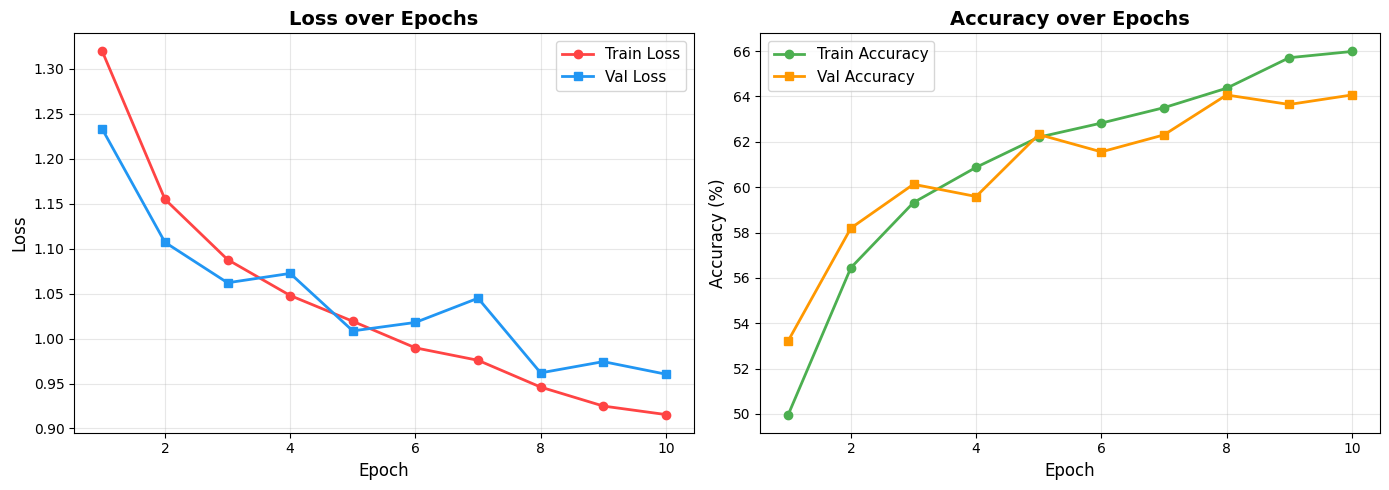

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, NUM_EPOCHS + 1)

# --- Loss ---
ax1.plot(epochs_range, history['train_loss'], 'o-', label='Train Loss', color='#FF4444', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 's-', label='Val Loss', color='#2196F3', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss over Epochs', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# --- Accuracy ---
ax2.plot(epochs_range, history['train_acc'], 'o-', label='Train Accuracy', color='#4CAF50', linewidth=2)
ax2.plot(epochs_range, history['val_acc'], 's-', label='Val Accuracy', color='#FF9800', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 9. Evaluation - Confusion Matrix

Generate predictions on the validation set and plot a confusion matrix to see which emotions are most confused with each other.

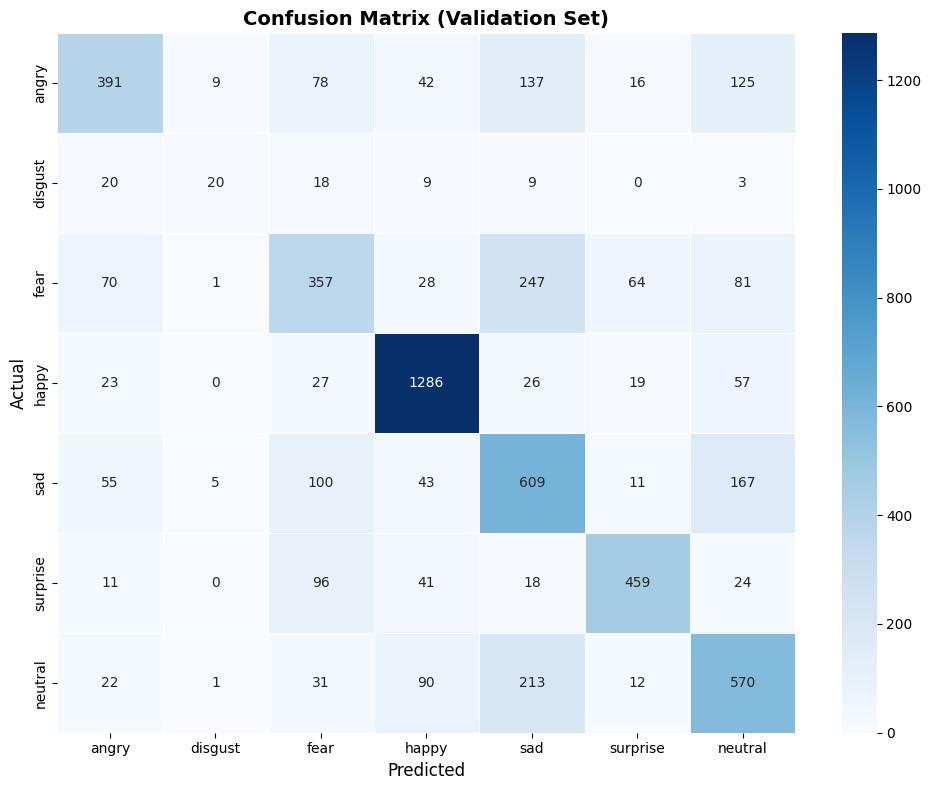

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Load best model
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=EMOTIONS, yticklabels=EMOTIONS, ax=ax,
            linewidths=0.5, linecolor='white')
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Confusion Matrix (Validation Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 9.1 Classification Report

Per-class precision, recall, and F1-score.

In [17]:
print(classification_report(all_labels, all_preds, target_names=EMOTIONS, digits=3))

              precision    recall  f1-score   support

       angry      0.660     0.490     0.563       798
     disgust      0.556     0.253     0.348        79
        fear      0.505     0.421     0.459       848
       happy      0.836     0.894     0.864      1438
         sad      0.484     0.615     0.542       990
    surprise      0.790     0.707     0.746       649
     neutral      0.555     0.607     0.580       939

    accuracy                          0.643      5741
   macro avg      0.626     0.570     0.586      5741
weighted avg      0.647     0.643     0.640      5741



---
## 10. Export Model for Production

Copy the best checkpoint to the main project's `models/cv/` folder so the Streamlit app can use it.

In [18]:
import shutil

PRODUCTION_PATH = os.path.join('..', 'models', 'cv', 'face_model.pth')

if os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(os.path.dirname(PRODUCTION_PATH), exist_ok=True)
    shutil.copy2(MODEL_SAVE_PATH, PRODUCTION_PATH)
    print(f"Model copied to: {PRODUCTION_PATH}")
    print(f"File size: {os.path.getsize(PRODUCTION_PATH) / (1024*1024):.1f} MB")
else:
    print(f"ERROR: {MODEL_SAVE_PATH} not found. Train the model first.")

Model copied to: ../models/cv/face_model.pth
File size: 8.8 MB


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## 11. Quick Inference Test

Test the trained model on a few random validation samples to visually verify predictions.

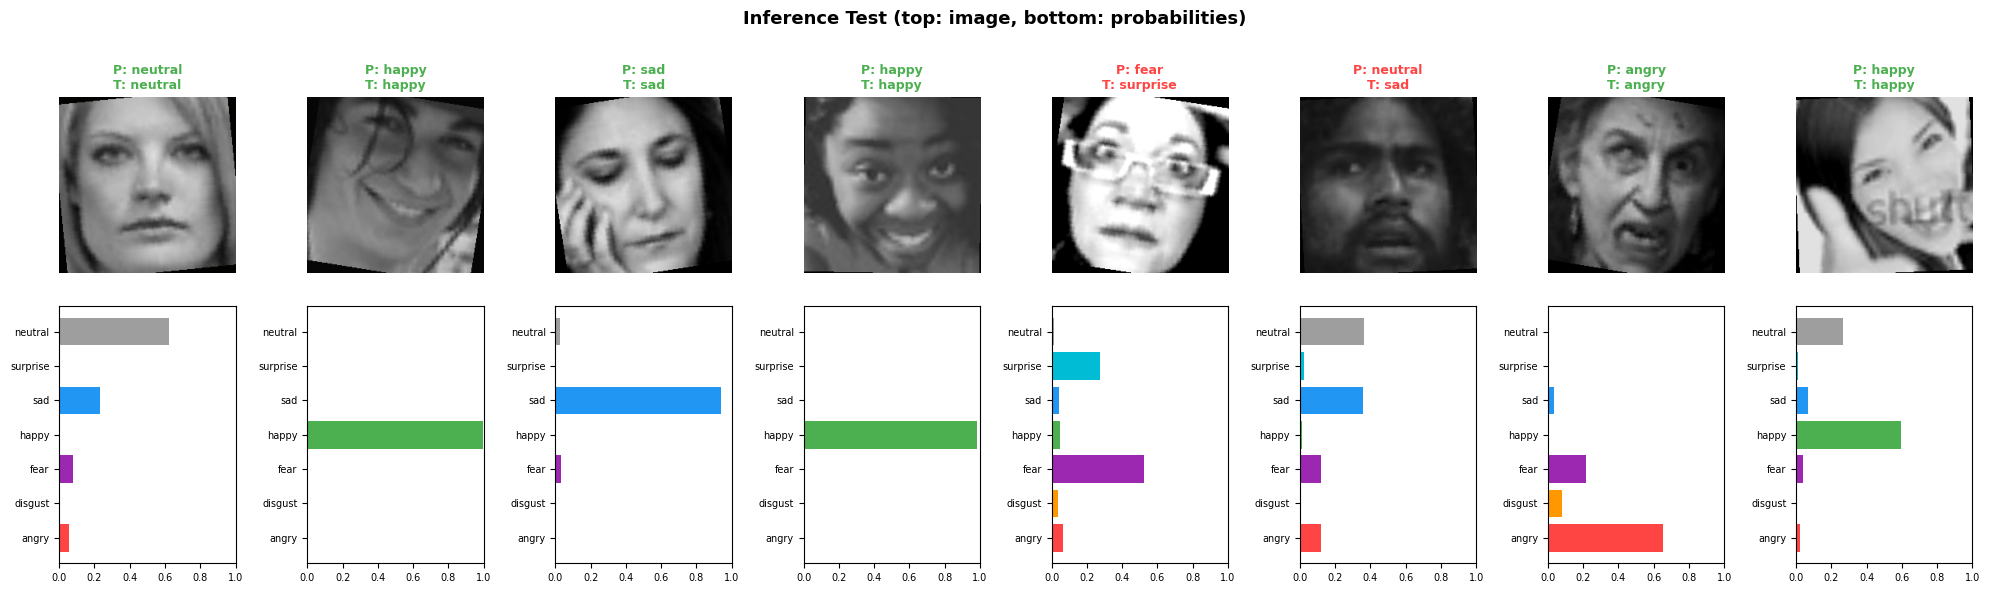

In [20]:
# Load best model
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.eval()

# Inverse normalization for display
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD)],
    std=[1.0/s for s in IMAGENET_STD],
)

# Get a batch from validation set
dataiter = iter(val_loader)
images, labels = next(dataiter)

# Predict
with torch.no_grad():
    outputs = model(images.to(DEVICE))
    probs = torch.nn.functional.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)

# Display first 8 samples
n_show = min(8, len(images))
fig, axes = plt.subplots(2, n_show, figsize=(n_show * 2.5, 6))
fig.suptitle('Inference Test (top: image, bottom: probabilities)', fontsize=13, fontweight='bold')

for i in range(n_show):
    # Show image
    img = inv_normalize(images[i]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    axes[0, i].imshow(img)

    pred_label = EMOTIONS[preds[i].item()]
    true_label = EMOTIONS[labels[i].item()]
    is_correct = pred_label == true_label
    title_color = '#4CAF50' if is_correct else '#FF4444'
    axes[0, i].set_title(f"P: {pred_label}\nT: {true_label}",
                          fontsize=9, color=title_color, fontweight='bold')
    axes[0, i].axis('off')

    # Show probability bar
    p = probs[i].cpu().numpy()
    bar_colors = [colors[j] for j in range(NUM_CLASSES)]
    axes[1, i].barh(EMOTIONS, p, color=bar_colors)
    axes[1, i].set_xlim(0, 1)
    axes[1, i].tick_params(axis='y', labelsize=7)
    axes[1, i].tick_params(axis='x', labelsize=7)

plt.tight_layout()
plt.show()

---

## Summary

| Step | Description |
|------|-------------|
| 1 | Loaded face emotion dataset organized by emotion folders |
| 2 | Applied data augmentation (flips, rotation, color jitter) |
| 3 | Split into 80% train / 20% validation |
| 4 | Used MobileNetV2 with transfer learning from ImageNet |
| 5 | Trained with Adam optimizer + LR scheduling |
| 6 | Evaluated with confusion matrix and classification report |
| 7 | Exported best model to `models/cv/face_model.pth` |

The exported model is used by the main Streamlit application for real-time face emotion detection in uploaded videos.